# Data analysis and modeling

In [ ]:
import numpy as np
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    silhouette_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
# Ignore runtime and future warnings
import warnings

warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
# Make sure all the directories where we'll save things exist
import os

os.makedirs("../figures", exist_ok=True)
os.makedirs("../results", exist_ok=True)
os.makedirs("../tables", exist_ok=True)

## Exploring relationships: Simple linear regression analysis

### Load the raw data

In [ ]:
import pandas as pd

penguins = pd.read_csv("../data/raw/penguins.csv")

penguins.head()

Let's see how much data is missing (NaN):

In [ ]:
penguins.isna().sum()

### Data cleaning

We use `dropna()` to remove rows with missing values
and `reset_index()` to reindex the dataset after dropping data. 

In [ ]:
penguins_sub = penguins[penguins["species"] != "Chinstrap"]
penguins_final = penguins_sub.dropna().reset_index(drop=True)
penguins_final.head()

### Exploratory data analysis (EDA)

Since this section focuses on simple linear regression, 
we will first examine potential linear relationships between variables 
in the dataset.

We can do this by creating scatter plots using any data visualization 
package, e.g., `matplotlib`, `seaborn`, or `plotly`.

Before constructing the regression model, 
let's explore relationships between variables using scatter plots. 
_Pairwise scatter plots_ help visualize potential linear relationships.  

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(penguins_final)

plt.savefig("../figures/pairplot.png", dpi=300)

### Observations

There are three strong linear relationships in the dataset:

1. Bill length and flipper length
2. Bill length and body mass
3. Flipper length (mm) and body mass

Let's focus on predicting body mass using bill length.

In [ ]:
ols_data = penguins_final[["bill_length_mm", "body_mass_g"]]

### Building and fitting the model

We use the `ols()` function from **statsmodels** to create the 
regression model.

In [ ]:
from statsmodels.formula.api import ols

ols_formula = "body_mass_g ~ bill_length_mm"

OLS = ols(formula=ols_formula, data=ols_data)
slr1_model = OLS.fit()

### **Interpreting Model Summary**  

Lastly, I will call the summary() function on the model object to obtain the regression coefficients and other statistical metrics. The output from model.summary() will help evaluate the model’s performance and interpret the strength and significance of the relationship between bill length and body mass.

I obtain the regression summary:  

In [ ]:
ms = slr1_model.summary()

ms_latex = ms.tables[0].as_latex_tabular()

# Export a LaTeX table
with open("../tables/ols-summary.tex", "w") as f:
    f.write(ms_latex)

ms

The summary provides important details, including:  
- **Intercept** – The predicted body mass when bill length is zero  
- **Slope** – The change in body mass per unit increase in bill length  
- **R-squared** – The proportion of variance in body mass explained by bill length  

The regression summary provides several key insights into the relationship between **bill length (mm)** and **body mass (g)** in penguins.  

### **Key Takeaways from the Model Output:**  
- **Intercept (-1707.29 g)**: This represents the predicted body mass when bill length is zero. While this value is not meaningful in a biological sense (since bill length cannot be zero for penguins), it helps define the regression line.  
- **Slope (141.19 g/mm)**: For every **1 mm increase in bill length**, the model predicts an **increase of 141.19 g** in body mass, on average.  
- **R-squared (0.769)**: Approximately **76.9% of the variation** in penguin body mass is explained by bill length. This suggests a strong linear relationship between the two variables.  
- **Adjusted R-squared (0.768)**: Since there is only one predictor, the adjusted R-squared remains close to the regular R-squared value, reinforcing that bill length is a strong predictor.  
- **F-statistic (874.3, p < 0.001)**: The extremely low p-value indicates that the model overall is statistically significant.  

Overall, this regression model provides a strong predictive relationship between **bill length** and **body mass** in penguins, with assumptions largely met. 

### **Visualizing the Regression Line**  

I will use the `regplot()` function from `seaborn` to visualize the regression line. This plot will help illustrate the relationship between bill length and body mass, showing how well the linear regression model fits the data.

In [ ]:
sns.regplot(x="bill_length_mm", y="body_mass_g", data=ols_data)

plt.savefig("../figures/regplot.png", dpi=300)

The **regression line** shows how body mass changes with bill length. 

The strong positive trend suggests that penguins with longer bills tend to have greater body mass. The regression line provides a visual representation of the **linear model fit**, and the shaded region represents the **confidence band** around the regression line.  

Given the **R-squared value of 0.769** from the OLS regression results, this model explains a significant proportion of the variation in body mass using bill length.

### **Checking Model Assumptions**  

A simple linear regression model must satisfy four key assumptions:  
1. **Linearity** – The relationship between X and Y is linear.  
2. **Normality** – The residuals follow a normal distribution.  
3. **Independent observations** – Observations are not correlated.  
4. **Homoscedasticity** – Residuals have constant variance.  

### **Checking Linearity and Independence**  

To evaluate the model assumptions, I will analyze the residuals, as they serve as an approximation of the errors. Since **linearity** was already assessed through the scatterplot matrix, and the assumption of **independent observations** is reasonable given that one penguin’s body mass or bill length is unlikely to influence another’s, we can check off assumptions 1 and 3. The next step is to assess the **normality** and **homoscedasticity** of residuals.

The normality and homoscedasticity assumptions pertain to the distribution of errors, meaning they can only be assessed after constructing the model. To evaluate these assumptions, I will examine the residuals, which serve as an approximation of the errors in the model.

To facilitate this, I will:
- Subset the X variable by isolating the `bill_length_mm` column.
- Save the predicted values from the model using the `model.predict(X)` function.
- Examine residual distributions and plots to assess normality and homoscedasticity.

In [ ]:
X = ols_data["bill_length_mm"]

fitted_values = slr1_model.predict(X)

### **Checking Normality of Residuals**  

Then, I will save the model residuals as a variable by using the `model.resid` attribute.

In [ ]:
residuals = slr1_model.resid


### Check the normality assumption

To check the normality assumption, I will create a histogram of the residuals using the `histplot()` function from the `seaborn` package.  

From the resulting histogram, I can assess whether the residuals follow a roughly normal distribution. If the distribution appears approximately bell-shaped and symmetric, the normality assumption is likely met. In this case, minor deviations are usually acceptable.

In [ ]:
fig = sns.histplot(residuals, kde=True)
fig.set_xlabel("Residual Value")
fig.set_title("Histogram of Residuals")
plt.savefig("../figures/residuals-histogram.png", dpi=300)
plt.show()

The shape of the distribution is approximately normal, though there is a slight right skew. The residuals are mostly centered around zero, which suggests that the assumption of **normally distributed errors** is reasonably met.  

While minor deviations from normality exist in the tails, the model's inference is unlikely to be significantly affected.

Another way to check the normality assumption is by creating a **quantile-quantile (Q-Q) plot**. If the residuals follow a normal distribution, the points in the Q-Q plot should align closely along a straight diagonal line from the bottom left to the top right.  

I will generate the Q-Q plot using the `qqplot` function from the `statsmodels.api` package. This visualization provides a more detailed look at how the residuals compare to a theoretical normal distribution.  

From the Q-Q plot, I can observe a pattern similar to the histogram. The residuals appear mostly normally distributed, though there may be slight deviations at the ends of the distribution. Minor deviations are generally acceptable unless they indicate strong skewness or heavy tails, which could impact the model’s validity.

In [ ]:
fig = sm.qqplot(slr1_model.resid, line="s")
plt.show()

The residuals align with the diagonal line, they are **approximately normal**.  

- The points largely follow the red diagonal line, suggesting that the residuals are **approximately normally distributed**.  
- However, slight deviations are observed at the extremes (tails), indicating minor departures from normality.  

Since the deviations are minimal, the normality assumption is likely satisfied for practical purposes. 

### **Checking Homoscedasticity**  

Lastly, I need to check the **homoscedasticity** assumption. This assumption requires that the residuals exhibit constant variance across all levels of the independent variable. If this assumption holds, the residuals should be randomly scattered around zero without forming any distinct pattern.  

To visualize this, I will create a **scatterplot of fitted values vs. residuals** using the `scatterplot()` function from the `seaborn` package. The fitted values will be placed on the x-axis, and the residuals will be on the y-axis.  

If the plot resembles a **random cloud** without a clear pattern (such as a funnel shape or curved trend), then the assumption of homoscedasticity is likely met. However, if I observe systematic patterns, such as increasing or decreasing spread, it could indicate heteroscedasticity, suggesting that the model might not fit all data points equally well.

I plot the **residuals vs. fitted values**:  

In [ ]:
fitted_values = slr1_model.predict(ols_data["bill_length_mm"])

fig = sns.scatterplot(x=fitted_values, y=residuals)

fig.axhline(0, color="red", linestyle="--")

fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")

plt.show()


The points are **randomly scattered**, the homoscedasticity assumption holds.  

- The points appear **randomly scattered** around the horizontal dashed red line at zero.  
- There is **no clear funnel shape** or systematic pattern, suggesting that the variance of residuals is relatively constant across fitted values.  
- This indicates that the **homoscedasticity assumption is likely met**.  

If heteroscedasticity were present, one would expect to see a fan-like shape, where residuals spread out more for certain fitted values.

### **Key Takeaways**  

- **Regression Relationship & Model Fit**: **Bill length is positively correlated with body mass**, with every **1 mm increase in bill length** leading to an **approximate 141.19 g increase in body mass**. The **R-squared value of 0.769** suggests that **bill length is a strong predictor of body mass**, explaining **76.9% of the variation**.  

- **Model Performance**: The **F-statistic (874.3, p < 0.001)** confirms that the model is **statistically significant**.  

- **Assumption Validation**:  
   - **Linearity**: Verified using a scatterplot and regression line.  
   - **Normality**: Residuals are approximately normally distributed, with minor deviations in the tails.  
   - **Homoscedasticity**: Residuals exhibit constant variance.  
   - **Independence**: Observations are independent, meaning measurements do not influence one another.  

- **Visualizations**:  
   - **Regression Plot**: Confirms the positive relationship between bill length and body mass.  
   - **Residual Plots** (histogram, Q-Q plot, scatterplot): Validate model assumptions.  

---

### **Presentation of Findings to Others**  

To effectively communicate these findings to my team and colleagues, I would highlight:  

- **Key Insight**: **Bill length is a strong predictor of body mass**, explaining **76.9% of the variation**. Longer bills correspond to significantly higher body mass.  

- **Implication for Conservation**: Understanding this correlation helps researchers assess factors affecting penguin health and growth.  

- **Visual Aids**:  
   - **Regression Plot**: Illustrates the relationship between bill length and body mass.  
   - **Residual Plots**: Demonstrate that model assumptions are met, ensuring statistical validity.  

---

### **Summary for Stakeholders**  

To provide stakeholders with a clear, actionable summary:  

- **Regression Results & Model Validity**:  
   - **Bill Length and Body Mass**: A **1 mm increase in bill length corresponds to an average 141.19 g increase in body mass**.  
   - **Model Accuracy**: The model explains **76.9% of the variation** in body mass, making it a reliable predictor.  

- **Assumption Validation**: The model meets key statistical assumptions—**linearity** (confirmed via scatterplot), **normality** (residuals follow a normal distribution), **independence** (no dependency in observations), and **homoscedasticity** (constant variance in residuals)—ensuring reliable results.  

# Building and Understanding Models with Statsmodels

### **Introduction**

In this section, I review key functions and documentation for modeling with **`Statsmodels`** using a subset of the penguin dataset. Building on the previous scenario, where I am a consultant for a scientific organization supporting penguin colonies, I aim to help staff members gain deeper insights into penguin populations. Previously, I analyzed only Gentoo and Adelie penguins, excluding Chinstrap. In this section, I focus solely on Chinstrap penguins, excluding the other two species. I cover data loading, cleaning, OLS regression modeling, and analyzing predictions and residuals.

In [ ]:
penguins.head()


This provides an overview of the dataset’s structure, allowing me to examine key variables before performing any cleaning or analysis.

### **Cleaning the Data**  

After loading the dataset, I will clean it by **isolating Chinstrap penguins** and **removing missing values**. Additionally, I will **reset the index** to ensure that row indices remain sequential.

In [ ]:
chinstrap_penguins = penguins[penguins["species"] == "Chinstrap"]

chinstrap_penguins.reset_index(inplace=True, drop=True)

chinstrap_penguins.head()


Resetting the index ensures that the dataset remains well-structured and easier to work with in subsequent steps.

To visualize relationships among variables, I use a **pairplot**:

In [ ]:
sns.pairplot(chinstrap_penguins)


This helps identify trends or patterns before model construction.

The variables displayed include:
- `bill_length_mm`
- `bill_depth_mm`
- `flipper_length_mm`
- `body_mass_g`

### Interpretation:
- The diagonal plots show the **distribution (histograms)** of each variable.
- The scatter plots show **pairwise relationships**:
  - `body_mass_g` appears to be positively correlated with `flipper_length_mm` and `bill_length_mm`.
  - `bill_depth_mm` does not show a strong correlation with the other features.

### **Setting Up for Model Construction**  

Now that my data is clean, I can visualize it and build a linear regression model. First, I will extract `bill_depth_mm` as my **X variable** and `flipper_length_mm` as my **Y variable**, which I am targeting.

In [ ]:
ols_data = chinstrap_penguins[["bill_depth_mm", "flipper_length_mm"]]


Since I am using **Statsmodels**, I will save the **Ordinary Least Squares (OLS) formula** as a string so the computer can interpret it for regression. The **Y variable**, `flipper_length_mm`, comes first, followed by a tilde (`~`) and the **X variable**, `bill_depth_mm`.

In [ ]:
ols_formula = "flipper_length_mm ~ bill_depth_mm"


This formula tells the model that **flipper length** is the dependent variable, and **bill depth** is the independent variable.


### **Constructing the Model**  

To build and fit the **OLS regression model**, the necessary function from **statsmodels** is already imported at the start of the notebook.

Next, I will pass the **OLS formula** and the saved dataset into the `ols()` function. Then, I will use the `.fit()` method to train the model on the data. Finally, I will call the `.summary()` method to generate the regression results.

In [ ]:
OLS = ols(formula=ols_formula, data=ols_data)
slr2_model = OLS.fit()

slr2_model.summary()


The regression output provides the **coefficient estimate** for `bill_depth_mm`, while the **R-squared value** indicates how well the model explains variation in the response variable.

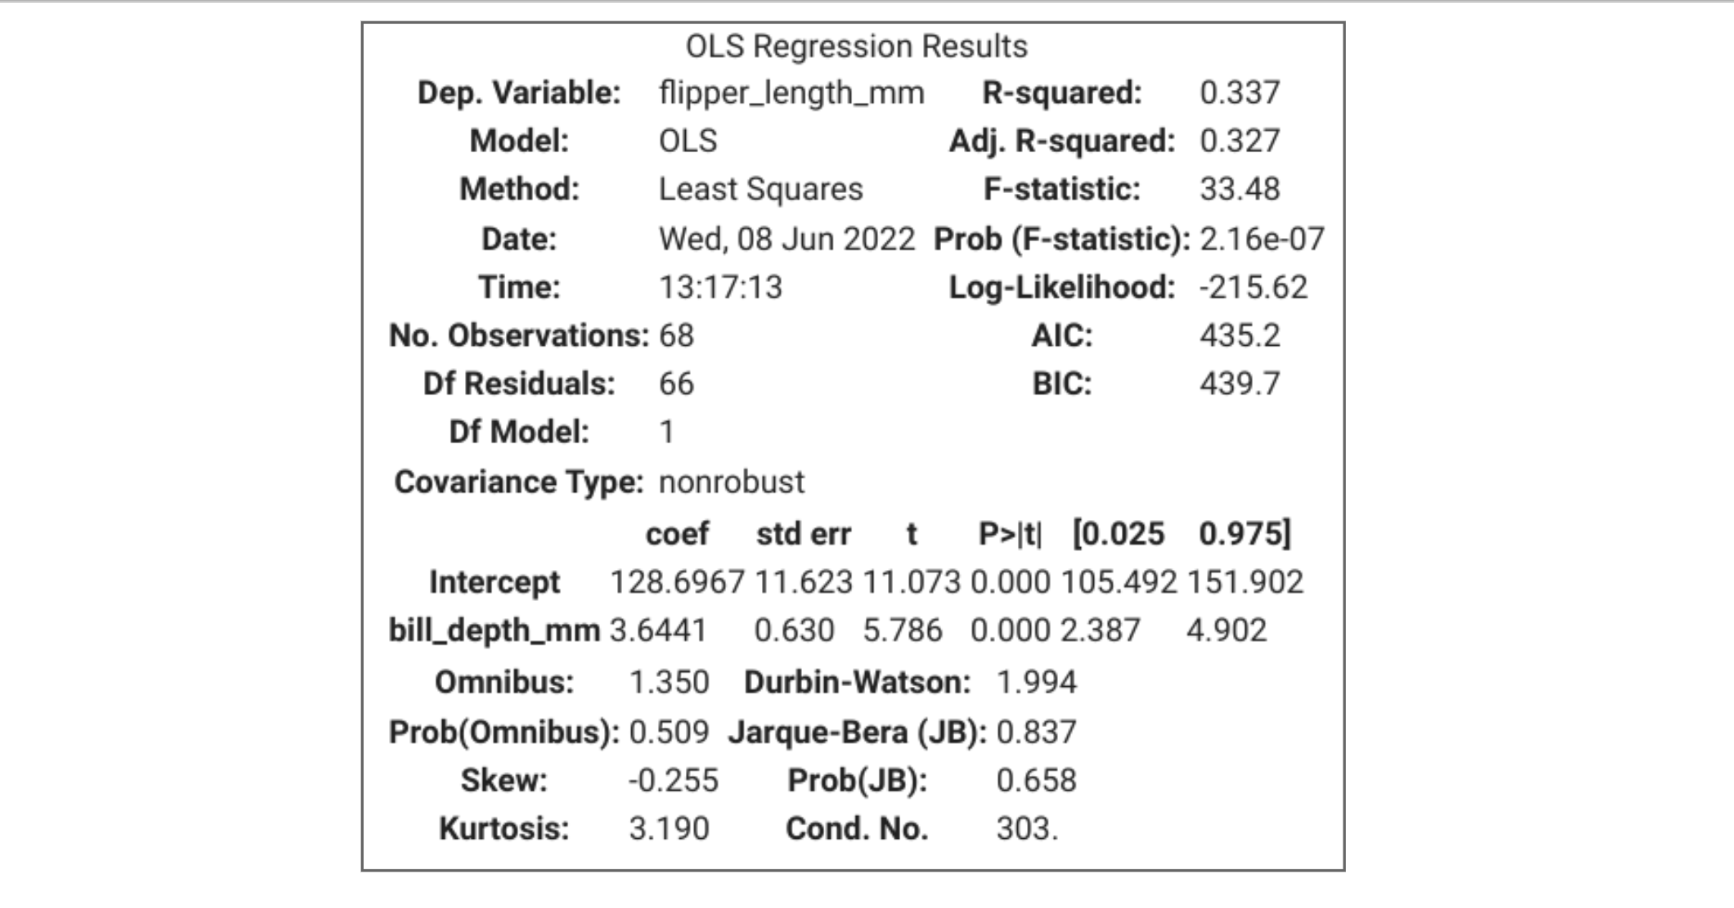

The summary highlights key insights such as:

- **Intercept**: 128.70, meaning when `bill_depth_mm` is zero, `flipper_length_mm` is estimated at 128.70.
- **Slope (bill_depth_mm coefficient)**: 3.64, indicating that for each 1 mm increase in bill depth, flipper length increases by approximately 3.64 mm.
- **R-squared**: 0.337, suggesting that 33.7% of the variation in `flipper_length_mm` is explained by `bill_depth_mm`.
- **P-value for bill_depth_mm**: 0.000, which is highly significant, meaning `bill_depth_mm` has a strong linear relationship with `flipper_length_mm`.

### **Model Predictions and Residual Analysis**  

Once the model is built, I can **generate predictions** and analyze the **residuals**.

### **Generating Predictions**  

I will use the model’s `predict()` method and pass an array containing the values of the independent variable(s) to generate predictions.

In [ ]:
predictions = slr2_model.predict(chinstrap_penguins[["bill_depth_mm"]])


In [ ]:
sns.regplot(x="bill_depth_mm", y="flipper_length_mm", data=ols_data)

The **scatterplot with regression line** confirms a moderate linear relationship, with some variability around the line.  

### **Analyzing Residuals**  

Residuals represent the difference between **observed** and **predicted** values. I first extract residual values:

In [ ]:
X = ols_data["bill_depth_mm"]

fitted_values = slr2_model.predict(X)
residuals = slr2_model.resid

To examine the distribution of residuals, I create a histogram:

In [ ]:
fig = sns.histplot(residuals)
fig.set_xlabel("Residual Value")
fig.set_title("Histogram of Residuals")
plt.show()

This histogram of residuals helps assess the model's fit by showing the distribution of errors. A roughly symmetric, bell-shaped pattern suggests that the residuals are normally distributed, supporting the assumptions of linear regression.

To assess normality, I generate a **Q-Q plot**:

In [ ]:
fig = sm.qqplot(slr2_model.resid, line="s")
plt.show()

This Q-Q plot compares the residuals to a normal distribution. Since most points align closely with the red diagonal line, the residuals appear to follow a normal distribution, supporting the assumption of normality in linear regression. However, slight deviations at the extremes suggest potential outliers or minor departures from normality.

Lastly, I generate a **residuals vs. fitted values plot** to assess the homoscedasticity assumption.

In [ ]:
fig = sns.scatterplot(x=fitted_values, y=residuals)
fig.axhline(0)
fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")
plt.show()

This residual plot shows the residuals against the fitted values. The residuals appear to be randomly scattered around zero, which suggests that the assumption of homoscedasticity (constant variance) is reasonable. However, if any patterns were present, such as a funnel shape or curvature, it would indicate heteroscedasticity or model misspecification.

These visualizations help identify whether residuals follow a normal distribution and whether the model meets linear regression assumptions.

### **Navigating Statsmodels Documentation**  

When working with a new Python package, referring to **official documentation** is crucial. Exploring **function parameters** and understanding their role in model construction is crucial.

### **Key Takeaways**  

- **Regression Insight**: **Bill depth is positively correlated with flipper length**, with a **1 mm increase in bill depth** leading to a **3.64 mm increase in flipper length**. The **R² = 0.337**, meaning bill depth explains **33.7% of the variation** in flipper length.  
- **Model Performance**: The model is **statistically significant (p < 0.001, F-statistic confirms fit)**.  
- **Assumption Checks**: Linearity verified via scatterplot, residuals are approximately normal, homoscedasticity holds, and no dependency issues observed.
- **Visualizations**: Regression and residual plots confirm assumptions and model validity.  

---

### **Presentation of Findings to Others**  

- **Key Insight**: **Bill depth predicts flipper length**, with a **3.64 mm increase per 1 mm increase in bill depth**.  
- **Research Implications**: Provides insights into Chinstrap penguin body structure.  
- **Visual Aids**: Regression plot shows the relationship, and residual plots validate assumptions.

---

### **Summary for Stakeholders**  

- **Findings**: A **1 mm increase in bill depth** leads to a **3.64 mm increase in flipper length**, explaining **33.7% of variation**.  
- **Model Reliability**: Significant and valid but could improve with additional predictors.  
- **Applications**: Expanding to **multivariable models**, such as multiple linear regression, to improve accuracy, which will be explored in the next section.

# Multiple Linear Regression: Techniques and Applications for Predictive Analytics

### **Introduction**

In this section, I will build a **multiple linear regression model** using Python to predict penguin body mass based on several predictors, including bill length, gender, and species. Multiple linear regression extends simple linear regression by modeling the relationship between one dependent variable and multiple independent variables. Using **pandas**, **seaborn**, and **statsmodels**, I will perform **data cleaning, exploratory data analysis (EDA), feature selection, model construction, and assumption checking** to ensure the model is both valid and interpretable. This structured approach will help me understand how these predictors influence penguin body mass and build a reliable predictive model.

To strengthen the analysis, I will incorporate **ANOVA (Analysis of Variance)** and **ANCOVA (Analysis of Covariance)** to test for significant differences in body mass across species and gender, both independently and while controlling for bill length. Additionally, I will use **Tukey's post hoc test** to identify specific pairwise differences between groups after model evaluation. These techniques will provide deeper insights into the relationships between predictors and the dependent variable, ensuring a robust and comprehensive analysis. By following this approach, I aim to interpret the results in a way that is both statistically sound and actionable for understanding penguin body mass variations.

In [ ]:
penguins.head()

From the first five rows of the dataset, I can see the following columns: `species`, `island`, `bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`, `body_mass_g`, and `sex`.The objective is to predict **body mass** (`body_mass_g`) based on several other variables, including **bill length** (`bill_length_mm`), **gender**, and **species**. 

There are also some missing values that need to be addressed.


### Data Preprocessing

The next step is to clean the dataset. This involves:

- Subsetting the relevant columns
- Renaming columns for consistency
- Dropping rows with missing values
- Resetting the index for easier manipulation

In [ ]:
penguins = penguins[["body_mass_g", "bill_length_mm", "sex", "species"]]

penguins.columns = ["body_mass_g", "bill_length_mm", "gender", "species"]

penguins.dropna(inplace=True)

penguins.reset_index(inplace=True, drop=True)

penguins.head()

At this point, the dataset is cleaned and ready for modeling.

### ANOVA for Species and Gender Effects

To confirm whether species and gender have significant effects on body mass, I performed **Analysis of Variance (ANOVA)**. This test helps determine whether there are statistically significant differences in body mass across species and gender groups.  

#### **ANOVA for Species**  

In [ ]:
anova_species = ols("body_mass_g ~ C(species)", data=penguins).fit()
print(anova_lm(anova_species))

- **F-statistic**: 341.89  
- **p-value**: < 0.001  
- **Interpretation**: The p-value for species is **< 0.001**, indicating that there are **significant differences in body mass across species**.  

#### **ANOVA for Gender** 

In [ ]:
anova_gender = ols("body_mass_g ~ C(gender)", data=penguins).fit()
print(anova_lm(anova_gender))

- **F-statistic**: 72.96  
- **p-value**: < 0.001  
- **Interpretation**: The p-value for gender is **< 0.001**, indicating that there are **significant differences in body mass between males and females**.  

- Both **species** and **gender** have significant effects on body mass, confirming that these categorical predictors are worth including in the regression model.  

### **Checking Model Assumptions**  
 
- **No Multicollinearity** – Independent variables are not highly correlated with each other.  

### **Feature Selection and Multicollinearity Check**  
Now that I have selected the relevant features, I need to check for **multicollinearity** among the independent variables. Multicollinearity can make it difficult to determine the individual effect of each predictor and may lead to unstable coefficient estimates.

To detect multicollinearity, I will compute the **Variance Inflation Factor (VIF)** for each predictor.

If multicollinearity is present, I may need to:
- **Remove highly correlated variables**
- **Combine similar predictors**
- **Use Ridge Regression (L2 regularization) instead of OLS**

Once I confirm that multicollinearity is not a major issue, I can proceed with splitting the data into a **training and testing set**.



In [ ]:
import json

# Select independent variables (X)
X_vif = penguins[["bill_length_mm", "gender", "species"]]

# Convert categorical variables into dummy variables properly
X_vif = pd.get_dummies(
    X_vif, drop_first=True, dtype=float
)  # Ensure numerical dtype

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_vif.values.astype(float), i)
    for i in range(X_vif.shape[1])
]

vif_results = vif_data.set_index("Variable")["VIF"].to_dict()

with open("../results/vif.json", "w") as f:
    json.dump(vif_results, f, indent=2)

# Display results
vif_data

### **Interpreting VIF Results**
- **VIF < 5** → Low correlation, no concern.  
- **VIF between 5 and 10** → Moderate correlation, might be an issue.  
- **VIF > 10** → High correlation, serious multicollinearity concern.  

The computed VIF values indicate that multicollinearity is not a major issue:  
- **bill_length_mm (4.66):** Relatively high but below the common threshold.  
- **gender_Male (2.23):** No significant multicollinearity.  
- **species_Chinstrap (1.76) & species_Gentoo (2.25):** Well within acceptable limits.  

Since none of the variables exceed the critical threshold of 5 or 10, I can confidently proceed with model building.

### **ANCOVA for Species and Gender with Covariate (Bill Length)**  

To test whether species and gender have significant effects on body mass after controlling for bill length, I performed **Analysis of Covariance (ANCOVA)**. This test allows us to assess the independent effects of categorical predictors while accounting for a continuous covariate.  

#### **ANCOVA Test**  

In [ ]:
ancova_model = ols(
    "body_mass_g ~ C(species) + C(gender) + bill_length_mm", data=penguins
).fit()
print(anova_lm(ancova_model))

### **Results**  

- **Species Effect**:  
  - The p-value for species is **< 0.001**, indicating significant differences in body mass across species after controlling for bill length.  
  - The **F-statistic (765.71)** and **mean square (7.26e+07)** suggest a strong effect of species on body mass.  

- **Gender Effect**:  
  - The p-value for gender is **< 0.001**, indicating significant differences in body mass between males and females after controlling for bill length.  
  - The **F-statistic (391.21)** and **mean square (3.71e+07)** highlight a substantial effect of gender on body mass.  

- **Bill Length Effect**:  
  - The p-value for bill length is **< 0.001**, indicating that bill length has a significant effect on body mass after accounting for species and gender.  
  - The **F-statistic (19.85)** and **mean square (1.88e+06)** suggest a moderate but meaningful effect of bill length on body mass.  

- **Residuals**:  
  - The residual mean square (**9.48e+04**) indicates the variance in body mass not explained by the predictors, which is relatively small compared to the explained variance.  

#### **Observation**:  
- Both **species** and **gender** remain significant predictors of body mass after controlling for bill length, confirming their importance in the regression model.  
- **Bill length** also has a significant effect, supporting its inclusion as a continuous predictor.  
- The high F-statistics and low p-values for all predictors suggest that the model effectively captures the relationships between the predictors and body mass.

### Create Holdout Sample

To evaluate the model, I will split the data into a training set and a holdout (testing) set. This can be done using **train_test_split** from Scikit-learn.

In [ ]:
penguins_X = penguins[["bill_length_mm", "gender", "species"]]
penguins_y = penguins[["body_mass_g"]]

X_train, X_test, y_train, y_test = train_test_split(
    penguins_X, penguins_y, test_size=0.3, random_state=42
)


Here, I have split the data into a 70% training set and a 30% testing set. The **random_state** is set to 42 to ensure reproducibility.

### Model Construction

In an earlier section, I explored the penguin dataset. I used scatterplots to perform exploratory data analysis and identified linear relationships between the following variables:

- Bill length (mm) and flipper length (mm)
- Bill length (mm) and body mass (g)
- Flipper length (mm) and body mass (g)

In this section, I'll focus on understanding some of the variables' relationships with body mass (g). I'll use one continuous X variable, bill length (mm), and the two categorical variables, gender and species.

First, I need to write out the formula as a string. I write the name of the y variable first, followed by the tilde (`~`), and then each of the X variables separated by a plus sign (`+`). For categorical variables, I'll use `C()` to indicate categorical variables, which tells the `ols()` function to one-hot encode them by making the alphabetically first class in the category the baseline.

In [ ]:
ols_formula = "body_mass_g ~ bill_length_mm + C(gender) + C(species)"

Now, I can save the `ols_data` as a dataframe, create the `ols` object, fit the model, and generate summary statistics. At this point, it would be a good idea to double-check the model assumptions about errors, specifically homoscedasticity and the normality of residuals.

In [ ]:
ols_data = pd.concat([X_train, y_train], axis=1)

OLS = ols(formula=ols_formula, data=ols_data)
mlr1_model = OLS.fit()

### **Checking Model Assumptions**  

A multiple linear regression model must satisfy five key assumptions:  
1. **Linearity** – The relationship between the dependent variable and each independent variable is linear.  
2. **Independence** – Observations are independent of each other. 
3. **Normality of Residuals** – Residuals are approximately normally distributed.  
4. **Homoscedasticity** – Residuals have constant variance across all levels of the independent variables.  
5. **No Multicollinearity** – Independent variables are not highly correlated with each other.  

### **Checking Linearity and Independence**  

- **Linearity**: The linearity assumption was assessed during exploratory data analysis (EDA) using scatterplots, which showed linear relationships between the predictors (`bill_length_mm`, `gender`, `species`) and the dependent variable (`body_mass_g`).  
- **Independence**: The dataset consists of individual penguins, and there are no repeated measurements for the same bird. Therefore, it is reasonable to assume that the observations are independent. 

### **Checking Normality of Residuals**  

To check the normality assumption, I examined the distribution of residuals using a histogram and a quantile-quantile (Q-Q) plot.  

#### **Histogram of Residuals**  


In [ ]:
residuals = mlr1_model.resid

fig = sns.histplot(residuals, kde=True)
fig.set_xlabel("Residual Value")
fig.set_title("Histogram of Residuals")
plt.show()

- The histogram indicates that the residuals follow an approximately normal distribution, with a slight deviation at the tails.  
- The residuals are centered around zero, suggesting that the normality assumption is reasonably met.  
- The presence of minor asymmetry does not significantly violate normality, but further diagnostic tests may be useful for confirmation.

#### **Q-Q Plot**  


In [ ]:
fig = sm.qqplot(mlr1_model.resid, line="s")
plt.title("Q-Q Plot of Residuals")
plt.show()

The Q-Q plot shows that the residuals largely align with the red diagonal line, indicating that they are approximately normally distributed.  

- Most points closely follow the theoretical quantiles, supporting the assumption of normality.  
- There are **minor deviations at the tails**, suggesting slight departures from normality, but they are not severe.  
- Given the overall alignment, the normality assumption is likely reasonable for model interpretation and inference.

### **Checking Homoscedasticity**  

To assess homoscedasticity, I created a scatterplot of fitted values vs. residuals.  


In [ ]:
# Compute fitted values and residuals
fitted_values = mlr1_model.fittedvalues
residuals = mlr1_model.resid

# Create the scatterplot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")

plt.show()

- The residuals are randomly scattered around the horizontal dashed red line at zero, indicating no obvious trend or systematic pattern.  
- Even though the residuals appear grouped due to categorical predictors, they are still scattered within each group, meaning the assumption holds within subgroups.  
- The spread of residuals remains fairly consistent across fitted values, suggesting that the variance of residuals is constant.  
- This supports the assumption of **homoscedasticity**, meaning the model does not exhibit heteroscedasticity (unequal variance of residuals).

Multicollinearity was assessed in the previous part to ensure that the predictor variables were not highly correlated, which could affect the stability and interpretability of the regression model.

Additionally, since this is not a time-series dataset, we do not need to check for autocorrelation in residuals

### Model Evaluation and Interpretation

I can use the `.summary()` function to generate a summary table of model results and statistics.

Once I have the summary table, I can interpret and evaluate the model. In the upper half of the table, several summary statistics are presented. I'll focus on `R-squared`, which indicates how much variation in body mass (g) is explained by the model. An `R-squared` of 0.85 is considered fairly high, meaning that 85% of the variation in body mass (g) is explained by the model.

In the lower half of the table, the beta coefficients estimated by the model are displayed, along with their corresponding 95% confidence intervals and p-values. From the p-value column, labeled `P>|t|`, I can see that all of the X variables are statistically significant, as the p-value is less than 0.05 for every X variable.


In [ ]:
mlr1_model.summary()

### Interpretation of Results

The **R-squared** value tells me how much of the variation in **body mass** (`body_mass_g`) is explained by the model. A higher R-squared indicates a better model fit.

I will also focus on the beta coefficients and their corresponding **p-values** to understand the relationships between the predictors and the outcome variable.

### **Model Summary**
- **R-squared:** 0.850  
  - This means that 85% of the variation in body mass (`body_mass_g`) is explained by the model. This is a strong fit, indicating that the model does a good job of capturing the relationship between the predictors and body mass.
- **Adj. R-squared:** 0.847  
  - The adjusted R-squared accounts for the number of predictors in the model. It's slightly lower than R-squared, which is expected, but still indicates a good fit.
- **F-statistic:** 322.6  
  - This high F-statistic and its associated low p-value (`1.31e-92`) indicate that the model is statistically significant, meaning that at least one of the predictor variables is related to body mass.


**Coefficients**: The coefficients represent the effect of each predictor variable on body mass, holding all other variables constant.  

- **Intercept: 2032.2111** – The intercept represents the predicted body mass when all predictor variables are zero. Although the intercept itself is not directly interpretable in this context, it serves as the baseline for the model.  

- **C(gender)[T.Male]: 528.9508** – Male penguins have, on average, **528.95 grams** more body mass than female penguins, holding all other variables constant.  

- **C(species)[T.Chinstrap]: -285.3865** – Chinstrap penguins have, on average, **285.39 grams less** body mass than Adelie penguins, holding all other variables constant.  

- **C(species)[T.Gentoo]: 1081.6246** – Gentoo penguins have, on average, **1,081.62 grams more** body mass than Adelie penguins, holding all other variables constant.  

- **bill_length_mm: 35.5505** – For every **1 mm increase** in bill length, a penguin's body mass increases by **35.55 grams**, holding all other variables constant.

### **Statistical Significance**
The p-values for all predictor variables are less than 0.05, which indicates that all the variables are statistically significant predictors of body mass.

- **C(gender)[T.Male]:** p = 0.000 (highly significant)
- **C(species)[T.Chinstrap]:** p = 0.008 (significant)
- **C(species)[T.Gentoo]:** p = 0.000 (highly significant)
- **bill_length_mm:** p = 0.000 (highly significant)

### **Confidence Intervals**
The 95% confidence intervals for the coefficients provide a range of plausible values for each coefficient. For instance:
- The coefficient for `C(gender)[T.Male]` is 528.95, with a 95% confidence interval of [420.37, 637.53]. This means we are 95% confident that the true effect of being male (compared to female) on body mass lies within this range.

To further illustrate these results, the following coefficient plot visualizes the estimated coefficients along with their 95% confidence intervals.

In [ ]:
# Extracting coefficients and their confidence intervals
coef_df = pd.DataFrame(mlr1_model.params, columns=["Coefficient"])
coef_df["Lower CI"] = mlr1_model.conf_int()[0]
coef_df["Upper CI"] = mlr1_model.conf_int()[1]

# Sorting for better visualization
coef_df = coef_df.sort_values(by="Coefficient")

# Plot
plt.figure(figsize=(8, 5))
plt.barh(coef_df.index, coef_df["Coefficient"], color="skyblue", alpha=0.8)
plt.errorbar(
    coef_df["Coefficient"],
    coef_df.index,
    xerr=[
        coef_df["Coefficient"] - coef_df["Lower CI"],
        coef_df["Upper CI"] - coef_df["Coefficient"],
    ],
    fmt="o",
    color="black",
    capsize=5,
)

plt.axvline(0, linestyle="--", color="red")  # Reference line at 0
plt.xlabel("Coefficient Value")
plt.ylabel("Predictor Variables")
plt.title("Coefficient Estimates with 95% Confidence Intervals")
plt.show()

### **Interpretation of Coefficient Estimates**  

The coefficient plot above presents the estimated effects of predictor variables on body mass (in grams), along with their 95% confidence intervals. The red dashed line at zero serves as a reference, indicating whether a predictor has a statistically significant effect. If a confidence interval crosses zero, the effect is not statistically significant.  

#### **Key Observations:**  

1. **Intercept:**  
   - The intercept has the largest coefficient, around 2000 grams, indicating the estimated body mass when all predictor variables are at their baseline (i.e., for female Adelie penguins with a bill length of zero, though this is not a meaningful real-world scenario).  
   - The wide confidence interval suggests some uncertainty in this estimate.  

2. **Species (Gentoo) Effect:**  
   - Being a Gentoo penguin significantly increases body mass, with an estimated effect of approximately 1300 grams compared to the reference species (Adelie).  
   - The confidence interval does not cross zero, confirming statistical significance.  

3. **Gender (Male) Effect:**  
   - Male penguins weigh significantly more than females, with an estimated increase in body mass of around 500 grams.  
   - The narrow confidence interval indicates a precise estimate.  

4. **Bill Length Effect:**  
   - Bill length has a small positive effect on body mass, though the estimate is close to zero.  
   - The confidence interval suggests some uncertainty, and the effect may not be practically significant.  

5. **Species (Chinstrap) Effect:**  
   - Being a Chinstrap penguin is associated with a decrease in body mass relative to Adelie penguins, with an estimated effect of around -400 grams.  
   - The confidence interval does not cross zero, confirming statistical significance.  

#### **Conclusion:**  
- **Species and gender are the most influential predictors** of body mass, with Gentoo penguins being the heaviest and males generally weighing more than females.  
- **Bill length has a relatively small effect,** suggesting that body mass is not strongly determined by this feature.  
- **The wide confidence interval for the intercept** suggests some variability in baseline body mass estimates, but the other predictors have relatively precise estimates.  

These findings align with biological expectations, as Gentoo penguins are known to be the largest species in the dataset, and males typically have higher body mass across species.

### Model Performance on Test Data

Now that I've trained and validated our model on the training data, I'll evaluate its performance on the unseen test data to assess how well it generalizes.


In [ ]:
y_pred = mlr1_model.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f} grams")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} grams")
print(f"R-squared (R²): {r2:.4f}")

### Visualizing Actual vs Predicted Values

Let's visualize how well this predictions match the actual values in the test set.

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2
)
plt.xlabel("Actual Body Mass (g)")
plt.ylabel("Predicted Body Mass (g)")
plt.title("Actual vs Predicted Body Mass on Test Set")
plt.show()

### Residual Analysis on Test Set

We should also check if our model assumptions hold on the test data.


In [ ]:
test_residuals = y_test.values.flatten() - y_pred

plt.figure(figsize=(12, 4))

# Residuals vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_pred, test_residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Test Set)")

# Histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(test_residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals (Test Set)")

plt.tight_layout()
plt.show()

### Interpretation of Results

### Test Set Performance Interpretation

The model achieved an R² of **0.8669**, meaning that approximately **86.69%** of the variance in body mass is explained by the model. This indicates a strong predictive capability.

- The **Mean Absolute Error (MAE)** of **215.37 grams** suggests that, on average, predictions deviate from the actual values by around **215 grams**.
- The **Mean Squared Error (MSE)** of **80,134.49** emphasizes the squared deviations, making larger errors more pronounced.
- The **Root Mean Squared Error (RMSE)** of **283.08 grams** provides a more interpretable metric, suggesting that most predictions fall within **±283 grams** of the actual values.

### Residual Analysis

- The **residuals vs. predicted values plot** does not show a clear pattern, suggesting that errors are randomly distributed, which is a good indication that the model's assumptions hold.
- The **residual histogram** approximates a normal distribution, further supporting the assumption of homoscedasticity (consistent variance of errors).

### Actual vs. Predicted Body Mass Plot

- Data points are clustered close to the diagonal line, indicating that the model is making accurate predictions.
- Some dispersion at higher body masses suggests slightly higher prediction errors for larger values, but no extreme systematic bias is visible.

### Observation

The model demonstrates strong predictive performance with a high R² value and low MAE/RMSE, confirming that it generalizes well to unseen data. The residuals show no significant violations of assumptions, reinforcing confidence in the model's reliability.

### **Tukey's Post Hoc Test for Pairwise Comparisons**  

To identify which specific species and genders differ significantly in body mass, I performed **Tukey's post hoc test**. This test compares all pairs of groups and identifies significant differences.  

#### **Tukey's Test for Species**  

In [ ]:
tukey_species = pairwise_tukeyhsd(
    endog=penguins["body_mass_g"], groups=penguins["species"], alpha=0.05
)
print(tukey_species)

### **Results**:  
- **Adelie vs. Chinstrap**: Mean difference = **26.92 g**, p = 0.9164 (not significant).  
- **Adelie vs. Gentoo**: Mean difference = **1386.27 g**, p < 0.001 (significant).  
- **Chinstrap vs. Gentoo**: Mean difference = **1359.35 g**, p < 0.001 (significant).  

#### **Observation**:  
- **Gentoo penguins** are significantly heavier than both **Adelie** and **Chinstrap penguins**.  
- There is no significant difference in body mass between **Adelie** and **Chinstrap penguins**.  
- These findings align with the regression model results and provide deeper insights into the pairwise differences between species.

### **Visualizing the Regression Line by Species and Gender**  

I will use the `lmplot()` function from `seaborn` to visualize the regression lines for different species and genders. This plot will help illustrate the relationship between bill length and body mass while accounting for species as separate facets and gender as a distinguishing factor within each species. The scatter points are displayed with reduced opacity (`alpha=0.5`) to improve visibility.

In [ ]:
sns.lmplot(
    x="bill_length_mm",
    y="body_mass_g",
    hue="gender",
    col="species",
    data=penguins,
    scatter_kws={"alpha": 0.5},
)
plt.show()

### **Interpretation of Regression Lines by Species and Gender**  

The regression plot above illustrates the relationship between **bill length (mm) and body mass (g)** for three penguin species (**Adelie, Chinstrap, and Gentoo**), while also differentiating by gender (**male and female**). The regression lines help visualize how body mass changes with bill length across species and genders.  

#### **Key Observations:**  

1. **Adelie Penguins:**  
   - Male Adelie penguins (blue points and line) generally have higher body mass than females (orange points and line) for the same bill length.  
   - The positive slope suggests a slight increase in body mass as bill length increases, but the relationship appears weak compared to other species.  

2. **Chinstrap Penguins:**  
   - Similar to Adelie penguins, males tend to have higher body mass than females.  
   - The regression lines for both genders show a mild positive trend, indicating a modest increase in body mass with bill length.  
   - There is more overlap between male and female distributions compared to Gentoo penguins, suggesting less pronounced sexual dimorphism.  

3. **Gentoo Penguins:**  
   - The strongest relationship between bill length and body mass is observed in Gentoo penguins.  
   - The regression lines for both males and females have a steeper slope, indicating that bill length is a more reliable predictor of body mass for this species.  
   - The separation between male and female groups is more distinct, reinforcing that male Gentoo penguins are significantly heavier than females for a given bill length.  

#### **Conclusion:**  
- **The relationship between bill length and body mass varies by species**, with **Gentoo penguins showing the strongest correlation**.  
- **Gender differences in body mass are evident across all species**, with males consistently weighing more than females.  
- **The regression lines suggest that bill length is a stronger predictor of body mass in Gentoo penguins** compared to Adelie and Chinstrap penguins, where the relationship is weaker.  

These findings highlight how **species-specific traits influence body size variations**, and they reinforce the importance of considering both species and gender when modeling penguin body mass.

### **Key Takeaways**  

- **Regression Insight**: **Bill length, gender, and species** significantly predict **body mass** (**R² = 0.850**).  
  - **1 mm increase in bill length** → **35.55 g increase** in body mass.  
  - **Males** weigh **528.95 g more** than females.  
  - **Gentoo penguins** weigh **1,081.62 g more** than Adelie, while **Chinstrap** weigh **285.39 g less** than Adelie.  
- **Model Performance**: **Statistically significant (p < 0.001, F-statistic = 322.6)**, confirming a strong fit.  
- **Assumption Checks**:  
  - **Linearity**: Verified via scatterplots and exploratory data analysis.  
  - **Normality**: Residuals are approximately normally distributed, with minor deviations at the tails.  
  - **Homoscedasticity**: Residuals show constant variance across fitted values.  
  - **Independence**: Observations are independent, as the dataset does not involve repeated measurements or clustering.  
  - **No Multicollinearity**: Variance Inflation Factor (VIF) values confirm that predictors are not highly correlated.  

- **Visualizations**:  
  - **Residual Plots**: Validate model assumptions, including normality and homoscedasticity.  
  - **Regression Plots**: Show the relationship between bill length and body mass, stratified by species and gender.  
  - **Coefficient Plot**: Highlights the impact of each predictor variable on body mass.  
  
---

### **Presentation of Findings to Others**  

- **Key Insight**: **Bill length, gender, and species strongly predict body mass**, explaining **85% of its variation**. Longer bills correlate with higher body mass, males are heavier, and Gentoo penguins weigh the most, while Chinstrap are lighter than Adelie.  
- **Research Implications**: Findings aid ecological and conservation studies.  
- **Visual Aids**: Residual plots validate assumptions, regression plots show predictor relationships, and a coefficient plot highlights variable impacts.

---

### **Summary for Stakeholders**  

- **Findings**: The model explains **85% of body mass variation**, showing strong predictive power. Longer bills correlate with higher body mass, males weigh more than females, and Gentoo penguins are the heaviest.  
- **Model Reliability**: Statistically significant, meets all regression assumptions, and residual diagnostics confirm its suitability.  
- **Applications**: Useful for conservation research, predicting body mass from traits. Future work could add predictors like flipper length and island location for improved accuracy.

# K-Means Clustering: Identifying Data Patterns and Grouping Similarities

### **Introduction**

In this section, I will use a **K-means clustering model** to segment the penguin dataset and uncover meaningful patterns. K-means is a widely used unsupervised learning technique that groups similar data points based on their features, making it valuable for identifying hidden structures in data. By applying this method, I aim to discover distinct clusters within the dataset and analyze how features such as body mass, bill length, and species influence these groupings. This process will provide key insights into the natural segmentation of penguins while enhancing my understanding of clustering techniques and their real-world applications.

### **Data Exploration and Preprocessing**  

Before clustering, I need to ensure the data is suitable for analysis. This includes:  

- Exploring the dataset  
- Checking for missing values  
- Encoding categorical variables  
- Dropping unnecessary columns  
- Scaling numerical features  


### **Exploring Data**  

To understand the distribution of species, I check the unique species types and their counts.  

In [ ]:
penguins = sns.load_dataset("penguins")
penguins.head()

In [ ]:
print(penguins["species"].unique())
print(penguins["species"].value_counts())

There are three species in the dataset: Adelie, Gentoo, and Chinstrap. The Chinstrap species is less common than the others, which could impact K-means clustering since the algorithm performs best with similarly sized groups.

**Why determine clusters if species information is already available?**  

- K-means assumes I do not already know the species count, allowing me to test if the algorithm can naturally infer the species.  
- Clustering may uncover additional patterns beyond species classification.  
- Clusters can be used as features in supervised learning models to improve predictive power.  

### **Checking for Missing Values**  

Since K-means does not handle missing values, I check for null values and remove any incomplete rows.  


In [ ]:
penguins.isna().sum()
penguins_subset = penguins.dropna(axis=0).copy()

To confirm that missing values are removed, I recheck for null values.  


In [ ]:
penguins_subset.isna().sum()


I then review the first 10 rows of the cleaned dataset.  


In [ ]:
penguins_subset.head(10)


### **Encoding Categorical Data**  

K-means requires numeric data. I ensure that the `sex` column values are standardized to uppercase and convert them into numeric format using one-hot encoding.  

In [ ]:
penguins_subset["sex"] = penguins_subset["sex"].str.upper()
penguins_subset = pd.get_dummies(
    penguins_subset, drop_first=True, columns=["sex"]
)

### **Dropping Unnecessary Columns**  

The `island` column is categorical and not relevant to clustering based on physical traits, so I drop it.  


In [ ]:
penguins_subset = penguins_subset.drop(["island"], axis=1)


### **Scaling the Features**  

Since K-means relies on distance-based calculations, I standardize numerical features using `StandardScaler`Since K-means clustering relies on distance to measure similarity between observations, it's crucial to scale the data before modeling. I will use **scikit-learn's** `StandardScaler` to standardize the features. This transformation rescales each value \( x_i \) by subtracting the feature’s mean and dividing by its standard deviation:  

$$
x_{\text{scaled}} = \frac{x_i - \text{mean}(X)}{\sigma}
$$


This process ensures that all features have a mean of **0** and a standard deviation of **1**, preventing any single feature from disproportionately influencing the clustering results.  

**Note:** The `species` column is not a numerical feature used for clustering, so it does not need to be scaled.

First, I copy all the features except the `'species'` column to a DataFrame `X`. 

In [ ]:
X = penguins_subset.drop(["species"], axis=1)


I will use `StandardScaler` from **scikit-learn** to scale the features in `X` and store the transformed data in a new variable called `X_scaled`. Here’s how I will do it:  

In [ ]:
X_scaled = StandardScaler().fit_transform(X)

### **Building and Evaluating K-means Models**  

I will define a function called `kmeans_inertia` to evaluate the **inertia** values for different numbers of clusters. This function will take `num_clusters` and `x_vals` (which corresponds to `X_scaled`) as inputs and return a list of inertia values for each k-value. Inside the function, I will use the K-means algorithm with a fixed `random_state` of 42 to ensure reproducibility.  

### **Computing Inertia for Multiple k-values**  

I define a function to compute inertia for values of `k` ranging from 2 to 10.  

In [ ]:
def kmeans_inertia(num_clusters, x_vals):
    """
    Computes inertia for different k-values.
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)
    return inertia

This function allows me to analyze how inertia changes with different cluster values, helping me determine the optimal number of clusters.

I will create a line plot using Matplotlib to visualize the relationship between `num_clusters` and `inertia`. This will help me identify the optimal number of clusters by observing the "elbow point," where inertia stops decreasing significantly.  

In [ ]:
num_clusters = list(range(2, 11))
inertia = kmeans_inertia(num_clusters, X_scaled)

sns.lineplot(x=num_clusters, y=inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

### **Finding the Elbow Point**  

I use the **elbow method** to identify the optimal `k`, where inertia starts decreasing at a slower rate. The plot suggests an elbow at `k = 6`, but to confirm this, I evaluate silhouette scores. While the inertia plot provides a good initial estimate, validating the choice with silhouette scores ensures that the clusters are well-separated and meaningful.


### **Evaluating Clustering Results**  

### **Computing Silhouette Scores**  

I evaluate the silhouette score using the `silhouette_score()` function, which measures how well-separated the clusters are. To compare silhouette scores for different values of `k` (ranging from 2 to 10), I write a function called `kmeans_sil` that takes in `num_clusters` and `x_vals` (`X_scaled`) and returns a list of silhouette scores for each `k`. This helps confirm the optimal number of clusters by ensuring that they are well-defined and distinct.

In [ ]:
def kmeans_sil(num_clusters, x_vals):
    """
    Computes silhouette scores for different k-values.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))
    return sil_score

I create a line plot to visualize the relationship between `num_clusters` and `sil_score`, using either seaborn or matplotlib. This plot helps identify the `k` value that maximizes the silhouette score, indicating the most well-defined clustering structure.

In [ ]:
sil_score = kmeans_sil(num_clusters, X_scaled)

sns.lineplot(x=num_clusters, y=sil_score, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

### **Interpreting Results**  

The silhouette scores confirm that **k = 6** provides the best-defined clusters, as it achieves the highest score. However, **k = 5** is also a strong contender, given its relatively high silhouette score. Since silhouette scores near 1 indicate well-separated clusters, while values closer to 0 suggest overlapping clusters, I rely on this metric to validate the optimal number of clusters. The plot supports the choice of six clusters, but five remains a viable alternative.

### **Assigning Clusters and Interpreting Results**  

#### Optimal k-value
Based on the evaluation, I fit a K-means model with `k = 6`. 

In [ ]:
kmeans6 = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans6.fit(X_scaled)

I print the unique cluster labels.  


In [ ]:
print("Unique labels:", np.unique(kmeans6.labels_))


I create a new column, **`cluster`**, in `penguins_subset` to store the cluster assignments. This step helps in analyzing how the K-means model grouped the data and whether the clusters make sense in the context of the penguins' physical traits. Since `penguins_subset` contains unscaled data, it provides a more intuitive understanding of the clusters and their characteristics.

In [ ]:
penguins_subset["cluster"] = kmeans6.labels_
penguins_subset.head()

### **Comparing Clusters to Species**  

To understand how clusters align with species, I use `groupby`.  

In [ ]:
penguins_subset.groupby(by=["cluster", "species"]).size()



### **Key Observations**  

I analyze the `groupby` outputs to understand how the clusters relate to penguin species and other physical traits. While each cluster includes a mix of species, some clusters show a strong alignment with specific species, suggesting that the model captures meaningful biological patterns. Other clusters may reflect differences based on sex or body size rather than species alone. To further explore these distinctions, I visualize the clustering results to identify patterns more clearly.

### **Visualizing Cluster-Species Relationship**  

I plot the distribution of species within each cluster.  

In [ ]:
penguins_subset.groupby(by=["cluster", "species"]).size().plot.bar(
    title="Clusters Differentiated by Species", figsize=(8, 5)
)
plt.show()

I use `groupby` to check whether each `'cluster'` can be distinguished based on both `'species'` and `'sex_MALE'`. This helps determine if the clustering is influenced by species differences, sex-based traits, or a combination of both. Analyzing these groupings provides insight into how well the K-means model captures meaningful patterns in the data.

In [ ]:
penguins_subset.groupby(
    by=["cluster", "species", "sex_MALE"]
).size().sort_values(ascending=False)

### **Key Observations**  

Even though clusters 2 and 3 were not entirely composed of a single species or sex, the `groupby` results show that species and sex were the primary factors influencing cluster assignments. This suggests that the K-means algorithm mainly grouped the penguins based on these attributes, highlighting their significance in the clustering process.

Finally, I interpret the `groupby` outputs and visualize the results. The graph confirms that each `'cluster'` can be differentiated by `'species'` and `'sex_MALE'`. Additionally, most clusters are predominantly composed of a single species and sex, reinforcing the idea that these attributes played a key role in the clustering process.

In [ ]:
penguins_subset.groupby(by=["cluster", "species", "sex_MALE"]).size().unstack(
    level="species", fill_value=0
).plot.bar(
    title="Clusters differentiated by species and sex",
    figsize=(6, 5),
    ylabel="Size",
    xlabel="(Cluster, Sex)",
)
plt.legend(bbox_to_anchor=(1.3, 1.0))

### **Key Takeaways**  

- **Clustering Insight**: K-means identified **6 clusters** primarily influenced by **species** and **sex**, with some clusters strongly aligned with specific species (e.g., Gentoo penguins). The **highest silhouette score** at **k = 6** indicates well-separated clusters.  
- **Model Performance**: A **silhouette score of ~0.5** suggests moderate separation, and the **elbow plot** confirmed **k = 6** as optimal.  
- **Assumption Checks**:  
  - Features were standardized, and categorical data (e.g., sex) was encoded for clustering.  
  - Missing values were removed to ensure data quality.  
- **Visualizations**:  
  - **Elbow Plot**: Identified the optimal number of clusters.  
  - **Silhouette Score Plot**: Validated cluster separation.  
  - **Cluster-Species Relationship Plot**: Showed alignment between clusters and species/sex.  

---

### **Presentation of Findings to Others**  

- **Key Insight**: Clustering uncovered **distinct groups** based on **species and sex**, reflecting biological patterns.  
- **Research Implications**: Findings support conservation efforts and ecological studies by identifying species subgroups.  
- **Visual Aids**: **Elbow plot** (optimal clusters), **silhouette plot** (cluster quality), **cluster-species plot** (species/sex patterns).

---

### **Summary for Stakeholders**  

- **Findings**: Identified **6 clusters** primarily driven by **species** and **sex**, with some clusters dominated by specific species. The **silhouette score (~0.5)** indicates moderate separation.  
- **Model Reliability**: Results align with biological patterns, validated through the **elbow method** and **silhouette scores**.  
- **Applications**: Supports **species subgroup identification** for conservation and extends to other ecological datasets.  

This analysis offers meaningful insights into penguin clustering, aiding ecological research and conservation efforts.

# Conclusion

The **Penguins Data Modeling and Analysis** project provided a thorough exploration of penguin morphology, revealing key relationships between physical attributes such as bill length, body mass, gender, and species. Through **EDA, data cleaning, regression modeling, ANOVA, ANCOVA, and K-means clustering**, I identified strong predictive relationships, significant differences in body mass across species and gender, and meaningful clustering patterns based on species and sex. These findings offer valuable insights into penguin biology, support ecological research, and inform conservation strategies aimed at sustaining penguin populations.

# Top Three Recommendations Based on Insights

1. **Develop Species-Specific Conservation Strategies**: Significant differences in body mass across species suggest that conservation efforts should be tailored to each species' ecological needs. Gentoo penguins, being the heaviest, may require different resource allocations compared to Chinstrap and Adelie penguins.  

2. **Incorporate Gender-Based Monitoring**: Since male penguins are consistently heavier than females, gender should be a key factor in ecological studies and conservation planning, particularly in areas such as foraging behavior, reproductive success, and health assessments.  

3. **Use Clustering for Targeted Conservation Efforts**: The K-means clustering analysis revealed distinct population segments based on species and gender. These clusters can be leveraged to implement focused conservation interventions, such as habitat protection for specific subgroups or targeted monitoring of at-risk populations.  

# Application of Insights

The findings from this analysis have several practical applications:  

- **Conservation Strategy Development**: Targeted conservation programs can be designed based on species and gender differences. For instance, Gentoo penguins, being the heaviest, may require different habitat protections and resource allocations compared to Adelie and Chinstrap penguins.  

- **Ecological Research and Monitoring**: Identifying key predictors of body mass, such as bill length and gender, helps refine ecological studies on foraging efficiency, reproductive success, and climate change impacts. Clustering insights can also guide monitoring efforts for specific subgroups.  

- **Educational Outreach and Policy Development**: The results can support public awareness campaigns about penguin conservation and influence policies on wildlife protection, ensuring resources are distributed based on species-specific needs.

# Next Steps

- **Expand Analysis with Additional Predictors**: Incorporate flipper length, island location, and environmental factors (e.g., temperature, food availability) for a more comprehensive understanding of penguin body mass and health.  

- **Develop Predictive Models**: Build models to forecast penguin population health based on physical traits and environmental conditions, aiding conservation planning.  

- **Conduct Longitudinal Studies**: Analyze trends in body mass, species distribution, and other traits over time to assess the impact of climate change and habitat loss.  

- **Integrate Environmental Data**: Combine penguin biological data with oceanographic and climate datasets to refine conservation strategies.  

- **Explore Advanced Clustering & Machine Learning**: Apply hierarchical clustering, PCA, or decision trees to uncover deeper patterns and relationships within the data.  

By expanding this research, future studies can enhance our understanding of penguin ecology, improve conservation efforts, and contribute to sustaining penguin populations.